## Simulate non-isoplanatic imaging for LOW at 100MHz.

### A set of model components are drawn from GLEAM. An ionospheric screen model is used to calculate the pierce points of the two stations in an interferometer for a given component. The model visibilities are calculated directly, and screen phase applied to obtain the corrupted visibility.

In [1]:
%matplotlib inline

import sys

from data_models.parameters import arl_path

import numpy

from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy import constants as const
from astropy.wcs.utils import pixel_to_skycoord

from matplotlib import pyplot as plt
from matplotlib import pylab as pylab

from data_models.memory_data_models import SkyModel
from data_models.polarisation import PolarisationFrame

from processing_library.util.coordinate_support import simulate_point, skycoord_to_lmn

from wrappers.serial.calibration.calibration_control import calibrate_function, create_calibration_controls
from wrappers.serial.skycomponent.operations import find_skycomponents
from wrappers.serial.visibility.base import create_blockvisibility, copy_visibility
from processing_library.image.operations import copy_image
from wrappers.serial.image.operations import show_image, qa_image
from wrappers.serial.simulation.testing_support import create_named_configuration, \
    create_low_test_skycomponents_from_gleam, create_unittest_components
from wrappers.serial.skycomponent.operations import filter_skycomponents_by_flux
from wrappers.serial.simulation.mpc import create_gaintable_from_screen, sum_visibility_over_partitions

from processing_components.simulation.mpc import expand_skymodel_by_skycomponents

from wrappers.serial.imaging.primary_beams import create_low_test_beam
from wrappers.serial.skycomponent.operations import apply_beam_to_skycomponent
from wrappers.serial.imaging.base import create_image_from_visibility, advise_wide_field
from wrappers.serial.image.operations import import_image_from_fits, export_image_to_fits
from wrappers.arlexecute.visibility.coalesce import convert_blockvisibility_to_visibility
from wrappers.arlexecute.skycomponent.operations import insert_skycomponent
from wrappers.arlexecute.image.operations import smooth_image

from workflows.arlexecute.pipelines.pipeline_arlexecute import continuum_imaging_list_arlexecute_workflow, \
    ical_list_arlexecute_workflow
from workflows.arlexecute.skymodel.skymodel_arlexecute import predictcal_skymodel_list_arlexecute_workflow
from workflows.serial.imaging.imaging_serial import invert_list_serial_workflow
from workflows.serial.imaging.imaging_serial import weight_list_serial_workflow, taper_list_serial_workflow
from workflows.serial.pipelines.pipeline_serial import continuum_imaging_list_serial_workflow, \
    ical_list_serial_workflow

from data_models.data_model_helpers import export_blockvisibility_to_hdf5

from wrappers.arlexecute.execution_support.arlexecute import arlexecute
from wrappers.arlexecute.execution_support.dask_init import get_dask_Client



In [2]:
import logging
def init_logging():
    logging.basicConfig(filename='low-sims-mpc.log',
                        filemode='a',
                        format='%(asctime)s,%(msecs)d %(name)s %(levelname)s %(message)s',
                        datefmt='%H:%M:%S',
                        level=logging.DEBUG)

init_logging()
log = logging.getLogger()
    
def lprint(*args):
    log.info(*args)
    print(*args)

In [3]:
pylab.rcParams['figure.figsize'] = (14.0, 14.0)
pylab.rcParams['image.cmap'] = 'rainbow'

In [4]:
c = get_dask_Client(
    memory_limit=32 * 1024 * 1024 * 1024, threads_per_worker=8, n_workers=1)
arlexecute.set_client(c)
# Initialise logging on the workers. This appears to only work using the process scheduler.
arlexecute.run(init_logging)

/Users/timcornwell/anaconda/envs/arlenv/lib/python3.6/site-packages/distributed/bokeh/core.py:55: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn('\n' + msg)


Creating LocalCluster and Dask Client
Diagnostic pages available on port http://127.0.0.1:58822


{'tcp://127.0.0.1:58843': None}

### Set up the observation: 10 minutes at transit, with 10s integration.

In [5]:
nfreqwin = 1
ntimes = 61
rmax = 550.0
dec = -55.0 * u.deg
frequency = numpy.linspace(1e8, 1.3e8, nfreqwin)
if nfreqwin > 1:
    channel_bandwidth = numpy.array(nfreqwin * [frequency[1] - frequency[0]])
else:
    channel_bandwidth = [0.3e8]
times = numpy.linspace(-300, 300.0, ntimes) * numpy.pi / (3600.0 * 12.0)

phasecentre = SkyCoord(ra=+0.0 * u.deg, dec=dec, frame='icrs', equinox='J2000')
lowcore = create_named_configuration('LOWBD2', rmax=rmax)

blockvis = create_blockvisibility(
    lowcore,
    times,
    frequency=frequency,
    channel_bandwidth=channel_bandwidth,
    weight=1.0,
    phasecentre=phasecentre,
    polarisation_frame=PolarisationFrame("stokesI"),
    zerow=True)

### Find sampling, image size, etc

In [6]:
wprojection_planes = 1
vis = convert_blockvisibility_to_visibility(blockvis)
advice = advise_wide_field(vis, guard_band_image=2.0, delA=0.02)

cellsize = advice['cellsize']
vis_slices = advice['vis_slices']
npixel = advice['npixels2']
if npixel > 1024:
    deconvolve_facets = 8
    deconvolve_overlap = 32
    deconvolve_taper = 'tukey'
else:
    deconvolve_facets = 1
    deconvolve_overlap = 0
    deconvolve_taper = 'tukey'

### Generate the model from the GLEAM catalog, including application of the primary beam.

Number of components 16


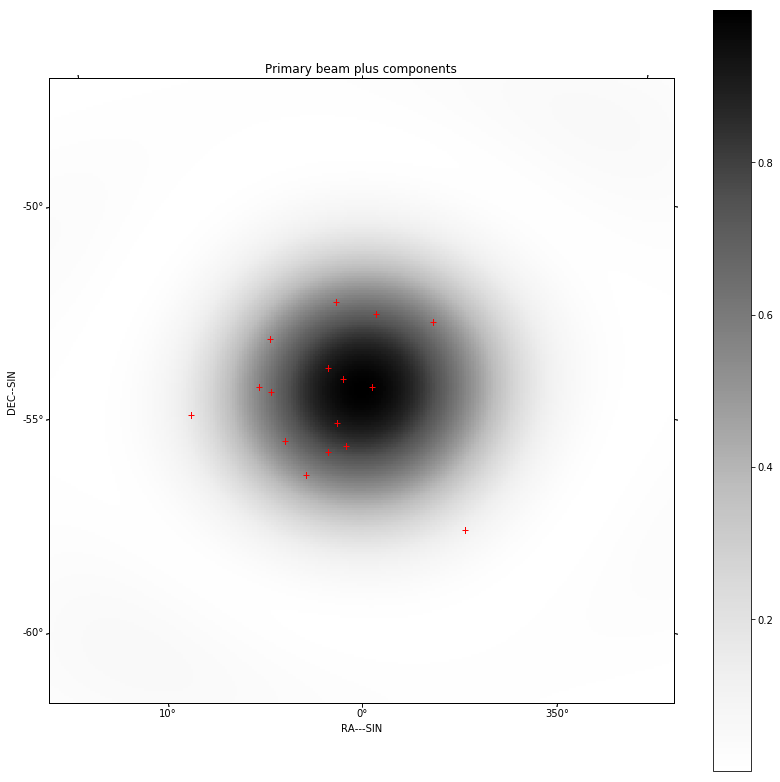

In [7]:
flux_limit=1.0
beam = create_image_from_visibility(
    blockvis,
    npixel=npixel,
    frequency=frequency,
    nchan=nfreqwin,
    cellsize=cellsize,
    phasecentre=phasecentre)
beam = create_low_test_beam(beam)

original_gleam_components = create_low_test_skycomponents_from_gleam(
    flux_limit=flux_limit,
    phasecentre=phasecentre,
    frequency=frequency,
    polarisation_frame=PolarisationFrame('stokesI'),
    radius=0.2)

pb_gleam_components = apply_beam_to_skycomponent(original_gleam_components,
                                                 beam)
actual_components = filter_skycomponents_by_flux(
    pb_gleam_components, flux_min=flux_limit)

show_image(
    beam,
    components=actual_components,
    cm='Greys',
    title='Primary beam plus components')

lprint("Number of components %d" % len(actual_components))

### We want each component to have a separate gaintable

In [8]:
gleam_skymodel = SkyModel(components=actual_components)
gleam_skymodel_expanded = expand_skymodel_by_skycomponents(gleam_skymodel)

### Fill the gaintables from the ionospheric screen model

In [9]:
screen = import_image_from_fits('low_screen_5000.0r0_0.100rate.fits')
gaintables = create_gaintable_from_screen(
    blockvis, gleam_skymodel.components, screen, scale=10.0)

### Now insert the gaintables into the skymodel

In [10]:
for i, sm in enumerate(gleam_skymodel_expanded):
    gleam_skymodel_expanded[i].gaintables = [gaintables[i]]

In [11]:
lprint(gleam_skymodel_expanded[0])

SkyModel: fixed: False
Skycomponent:
	Name: GLEAM J234118-581606
	Flux: [[1.9333297]]
	Frequency: [1.e+08]
	Direction: <SkyCoord (ICRS): (ra, dec) in deg
    (355.32681274, -58.26833344)>
	Shape: Point
	Params: {}
	Polarisation frame: stokesI


GainTable:
	Times: 61
	Data shape: (61,)
	Receptor frame: stokesI



### Now predict the visibility for each component and apply the gaintable, returning a list of visibilites, one for each component. We then sum these to obtain the total predicted visibility.

In [12]:
blockvis_list = [blockvis for i, b in enumerate(gleam_skymodel_expanded)]
blockvis_list = arlexecute.scatter(blockvis_list)
blockvis_list = predictcal_skymodel_list_arlexecute_workflow(
    blockvis_list, gleam_skymodel_expanded, context='2d')
blockvis_list = arlexecute.compute(blockvis_list, sync=True)
total_blockvis = sum_visibility_over_partitions(blockvis_list)

arlexecute.compute: Execution using Dask took 21.615 seconds


### Export visibility to HDF5

In [13]:
blockvis_h5 = export_blockvisibility_to_hdf5(blockvis_list, 
                                                   'low-sims-gleam_blockvis_list_rmax%.1f.hdf5' % rmax)
total_blockvis_h5 = export_blockvisibility_to_hdf5(total_blockvis, 
                                                   'low-sims-gleam_total_blockvis_rmax%.1f.hdf5' % rmax)

### Calculate the distorted image

In [14]:
model = create_image_from_visibility(
    blockvis,
    npixel=npixel,
    frequency=frequency,
    nchan=nfreqwin,
    cellsize=cellsize,
    phasecentre=phasecentre)

vis = convert_blockvisibility_to_visibility(total_blockvis)
vis = weight_list_serial_workflow([vis], [model])[0]
vis = taper_list_serial_workflow([vis], 0.003 * 750.0 / rmax)[0]

model.data[...] =0.0
vis_list = arlexecute.scatter([vis])
model_list = arlexecute.scatter([model])

cimg_list = continuum_imaging_list_arlexecute_workflow(
    vis_list,
    model_imagelist=model_list,
    context='2d',
    scales=[0, 3, 10],
    algorithm='msclean',
    niter=1000,
    fractional_threshold=0.3,
    threshold=0.01,
    nmajor=10,
    gain=0.25,
    psf_support=128,
    deconvolve_facets=deconvolve_facets,
    deconvolve_overlap=deconvolve_overlap,
    deconvolve_taper=deconvolve_taper)
    
deconvolved, residual, restored = arlexecute.compute(cimg_list, sync=True)



arlexecute.compute: Execution using Dask took 506.274 seconds


Quality assessment:
	Origin: qa_image
	Context: 
	Data:
		shape: '(1, 1, 256, 256)'
		max: '2.2644729589283146'
		min: '-1.6709856872922377'
		rms: '0.11091641756464049'
		sum: '923.3253721328496'
		medianabs: '0.018025777059294285'
		median: '0.00041256098556626095'



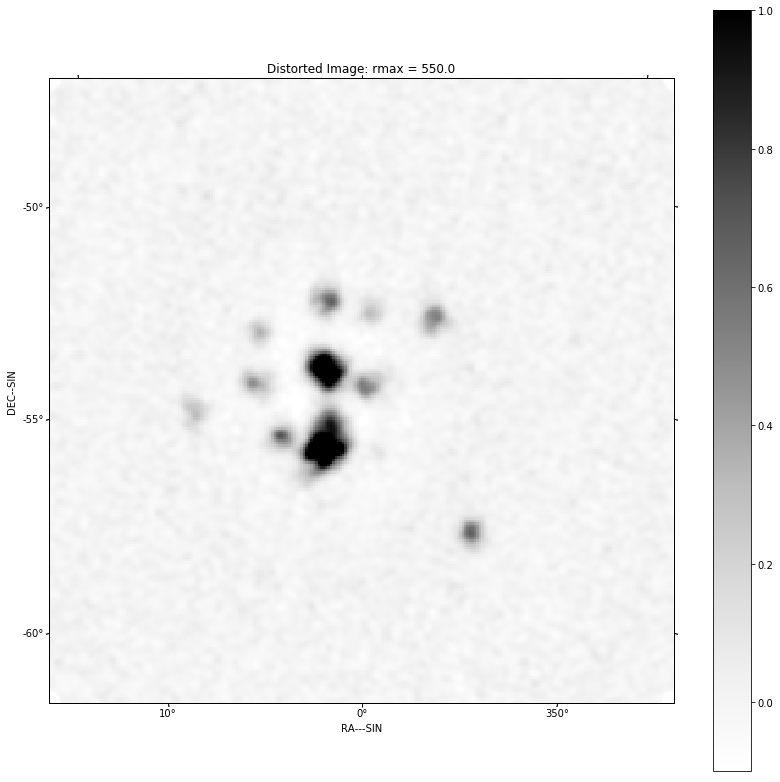

<Figure size 1008x1008 with 0 Axes>

In [15]:
lprint(qa_image(restored[0]))
show_image(
    restored[0],
    cm='Greys',
    title='Distorted Image: rmax = %.1f' % rmax,
    vmax=1.0,
    vmin=-0.1)
plt.show()
export_image_to_fits(restored[0],
                     'low-sims-gleam_distorted_restored_rmax%.1f.fits' % rmax)
plt.savefig('low-sims-gleam_distorted_restored_rmax%.1f.png' % rmax)
plt.show()

In [16]:
controls = create_calibration_controls()

controls['T']['first_selfcal'] = 0
controls['T']['phase_only'] = True
controls['T']['timescale'] = 'auto'

In [17]:
model.data[...] =0.0
vis_list = arlexecute.scatter([vis])
model_list = arlexecute.scatter([model])

ical_list = ical_list_arlexecute_workflow(
    [vis],
    model_imagelist=[model],
    context='2d',
    scales=[0, 3, 10],
    algorithm='msclean',
    niter=1000,
    fractional_threshold=0.3,
    threshold=0.01,
    nmajor=10,
    gain=0.25,
    psf_support=128,
    deconvolve_facets=deconvolve_facets,
    deconvolve_overlap=deconvolve_overlap,
    deconvolve_taper=deconvolve_taper,
    timeslice='auto',
    global_solution=False,
    do_selfcal=True,
    calibration_context='T',
    controls=controls)
    
deconvolved, residual, restored = arlexecute.compute(ical_list, sync=True)

/Users/timcornwell/anaconda/envs/arlenv/lib/python3.6/site-packages/distributed/worker.py:901: UserWarning: Large object of size 309.95 MB detected in task graph: 
  (<data_models.memory_data_models.Visibility object at 0x1218d7908>,)
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  % (format_bytes(len(b)), s))


arlexecute.compute: Execution using Dask took 1330.982 seconds


Quality assessment:
	Origin: qa_image
	Context: 
	Data:
		shape: '(1, 1, 256, 256)'
		max: '1.0349620923051641'
		min: '-0.0874297721622362'
		rms: '0.07119849584579849'
		sum: '710.8741533596941'
		medianabs: '0.013432906159769803'
		median: '0.00036458041655966706'



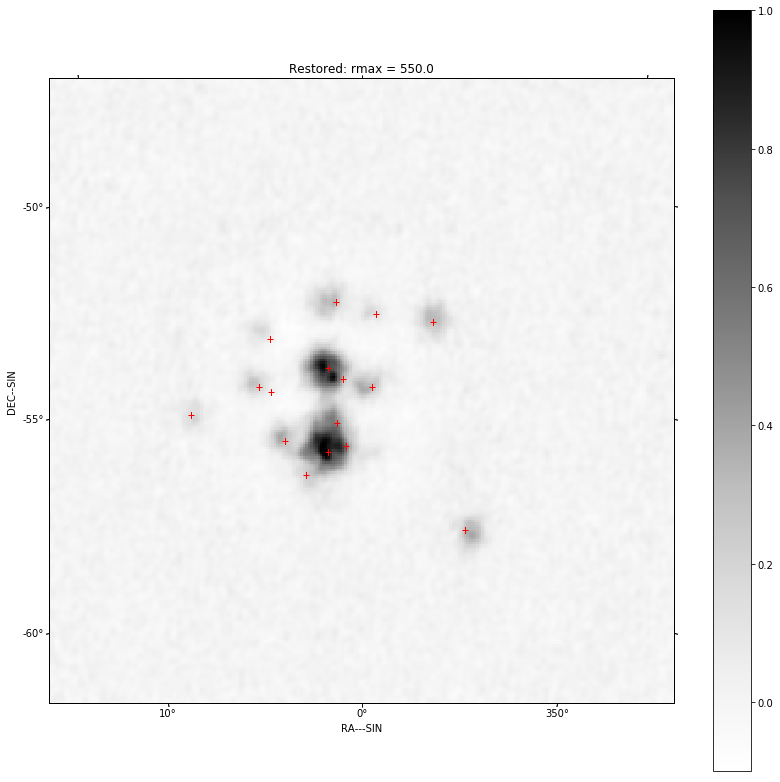

<Figure size 1008x1008 with 0 Axes>

In [18]:
lprint(qa_image(restored[0]))
show_image(
    restored[0],
    cm='Greys',
    title='Restored: rmax = %.1f' % rmax,
    components=actual_components,
    vmax=1.0,
    vmin=-0.1)
plt.show()
export_image_to_fits(restored[0],
                     'low-sims-gleam_restored_rmax%.1f.fits' % rmax)
plt.savefig('low-sims-gleam_restored_rmax%.1f.png' % rmax)
plt.show()

Quality assessment:
	Origin: qa_image
	Context: 
	Data:
		shape: '(1, 1, 256, 256)'
		max: '9.681926964649058'
		min: '0.0'
		rms: '0.16681340090429317'
		sum: '819.9644683107487'
		medianabs: '0.0'
		median: '0.0'



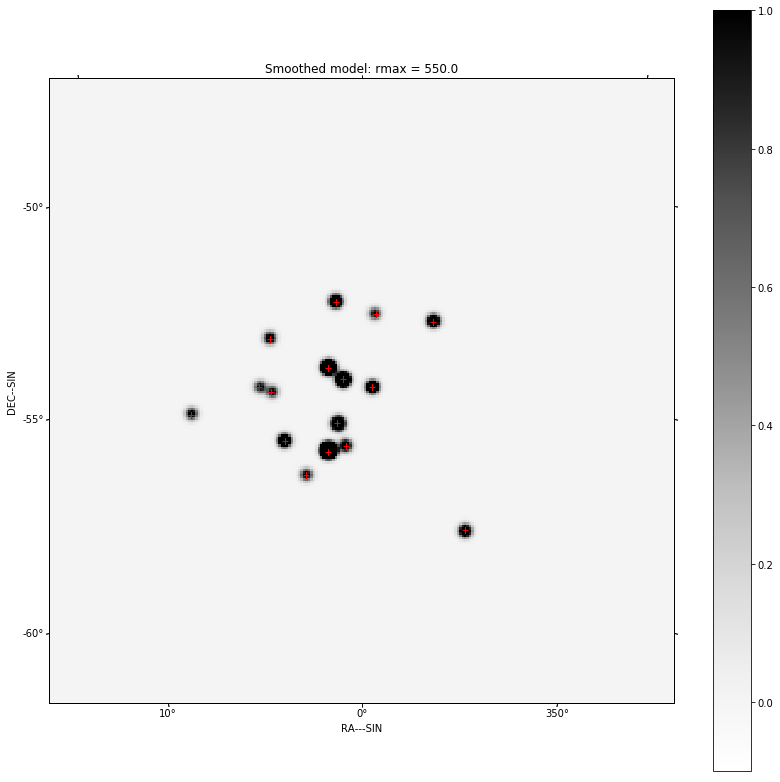

<Figure size 1008x1008 with 0 Axes>

In [19]:
smodel = create_image_from_visibility(
    blockvis,
    npixel=npixel,
    frequency=frequency,
    nchan=nfreqwin,
    cellsize=cellsize,
    phasecentre=phasecentre)
smodel = insert_skycomponent(smodel, actual_components)
smodel = smooth_image(smodel, 1.75)
lprint(qa_image(smodel))
show_image(
    smodel,
    cm='Greys',
    title='Smoothed model: rmax = %.1f' % rmax,
    components=actual_components,
    vmax=1.0,
    vmin=-0.1)
plt.show()
export_image_to_fits(restored[0],
                     'low-sims-gleam_smodel_rmax%.1f.fits' % rmax)
plt.savefig('low-sims-gleam_smodel_rmax%.1f.png' % rmax)
plt.show()